# Using ARIMA predict covid cases

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import probplot
import seaborn as sns
import datetime as dt
from datetime import datetime
import altair as alt
#plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':120})

In [2]:
df_confirm = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_confirm = df_confirm.groupby('Country/Region').sum().drop(['Lat','Long'],axis=1)
df_confirm.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,54403,54483,54559,54595,54672,54750,54854,54891,54939,55008
Albania,0,0,0,0,0,0,0,0,0,0,...,69916,70655,71441,72274,72812,73691,74567,75454,76350,77251
Algeria,0,0,0,0,0,0,0,0,0,0,...,104852,105124,105369,105596,105854,106097,106359,106610,106887,107122
Andorra,0,0,0,0,0,0,0,0,0,0,...,9379,9416,9499,9549,9596,9638,9716,9779,9837,9885
Angola,0,0,0,0,0,0,0,0,0,0,...,19177,19269,19367,19399,19476,19553,19580,19672,19723,19782


In [3]:
df_trans = df_confirm.transpose()
df_trans['World'] = df_trans.sum(axis =1)
df = df_trans.set_index(pd.DatetimeIndex(pd.to_datetime(df_trans.index.values,format="%m/%d/%y")))
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 375 entries, 2020-01-22 to 2021-01-30
Columns: 193 entries, Afghanistan to World
dtypes: int64(193)
memory usage: 568.4 KB


In [4]:
top_20_countries = df.iloc[-1,:].sort_values(ascending =False).head(25).index.tolist()

In [5]:
LAST_DATE = df.index[-1]
LAST_DATE

Timestamp('2021-01-30 00:00:00')

In [6]:
def get_stationarity(timeseries,window = 5):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

**Case Chart**

/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


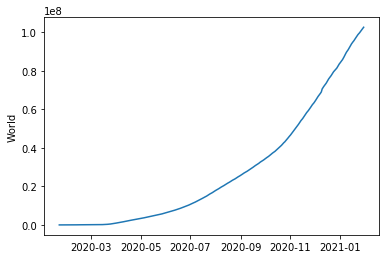

In [7]:
sns.lineplot(x=df.index,y=df.World)
plt.show()

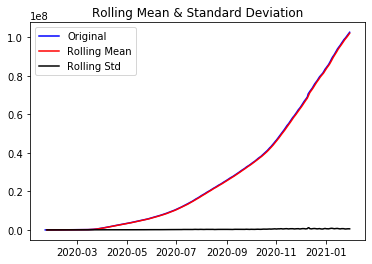

ADF Statistic: 0.23753227712872854
p-value: 0.9742898231284991
Critical Values:
	1%: -3.448493650810824
	5%: -2.8695352280356556
	10%: -2.5710293341377715


In [8]:
get_stationarity(df['World'],window=3)

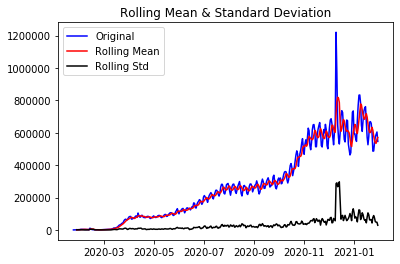

ADF Statistic: -0.8048164012038294
p-value: 0.8177031904945335
Critical Values:
	1%: -3.448493650810824
	5%: -2.8695352280356556
	10%: -2.5710293341377715


In [9]:
df_minusMA3 = df['World']-df['World'].rolling(window=3).mean()
get_stationarity(df_minusMA3.dropna())

**Case 1st diff chart**

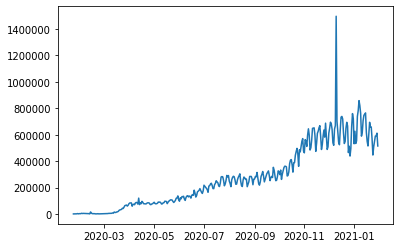

In [10]:
df_diff = df['World'].diff()
plt.plot(df_diff)

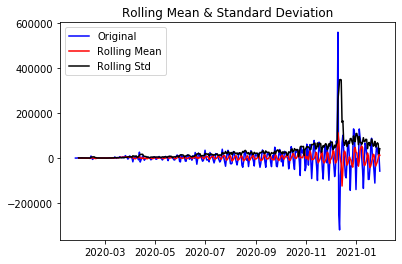

ADF Statistic: -5.511850824738032
p-value: 1.9640757500188464e-06
Critical Values:
	1%: -3.4489583388155194
	5%: -2.869739378430086
	10%: -2.5711381780459


In [11]:
df_diff_minusMA3 = df_diff - df_diff.rolling(window=3).mean()
get_stationarity(df_diff_minusMA3.dropna())

## ARIMA Analysis
* ARIMA(p,d,q)

    AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.\
    I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.\
    MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
* Precedure
    1. Transform unstationary (varied with time) to stationary --> Time shift transformation, log transformation, etc.), 
    2. determine hyperparameter (p,d,q) --> Plot ACF/PACF to determine p,q, see after how many lags, correlation became unsignificant (either equals to 0 or some threshold like 0.5), d can be detertime by diff order
    3. Peformance Check --> Residual plot and MSE.

**Split Data**
* Doing with (90%, 10%)

In [12]:
PRED =30

In [13]:
df_train = df[:-PRED]
df_test = df[-PRED:]

### 1.Transformation and Stationary Test

In [14]:
data = df_train['World']
data

2020-01-22         557
2020-01-23         655
2020-01-24         941
2020-01-25        1433
2020-01-26        2118
                ...   
2020-12-27    80878004
2020-12-28    81374381
2020-12-29    82036976
2020-12-30    82796757
2020-12-31    83519625
Name: World, Length: 345, dtype: int64

1. **Log transformation**
2. **1st/2nd diff**

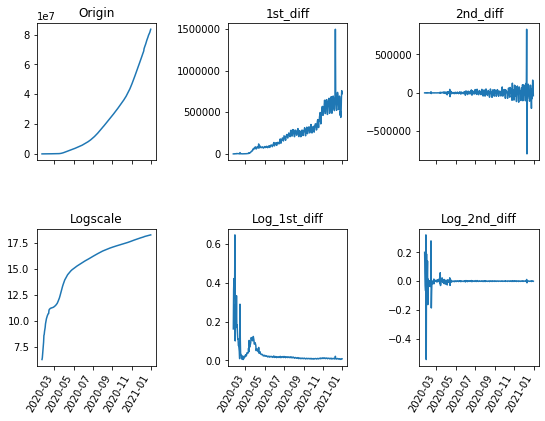

In [18]:
data = df_train['World']
fig, axes = plt.subplots(2, 3, figsize=(9,7))
plt.subplots_adjust(wspace=0.6,hspace=0.5,)
# origin
axes[0,0].plot(data)
axes[0,1].plot(data.diff().dropna())
axes[0,2].plot(data.diff().diff().dropna())
axes[0,0].set_title('Origin')
axes[0,1].set_title('1st_diff')
axes[0,2].set_title('2nd_diff')
# loglize
data = np.log(data)
axes[1,0].plot(data)
axes[1,1].plot(data.diff().dropna())
axes[1,2].plot(data.diff().diff().dropna())
axes[1,0].set_title('Logscale')
axes[1,1].set_title('Log_1st_diff')
axes[1,2].set_title('Log_2nd_diff')
# # trim to 250 points
# data = data[-250:]
# axes[2,0].plot(data)
# axes[2,1].plot(data.diff().dropna())
# axes[2,2].plot(data.diff().diff().dropna())
# axes[2,0].set_title('Logscale_250')
# axes[2,1].set_title('Log_250_1st_diff')
# axes[2,2].set_title('Log_250_2nd_diff')
fig.autofmt_xdate(rotation=60)
plt.show()
fig.savefig("_images/diff.png")

**ADF method to test stationarity**


In [19]:
def ADF_test(data):
    result = adfuller(data)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [20]:
data = df_train['World']
data_diff2 = data.diff().diff().dropna()
data_log_diff = np.log(data).diff().dropna()
data_log_diff2 = np.log(data).diff().diff().dropna()
data_250_log_diff2 = np.log(data)[-250:].diff().diff().dropna()

In [21]:
ADF_test(data_diff2)

ADF Statistic: -5.311191156322821
p-value: 5.190821735252599e-06
Critical Values:
	1%: -3.4503836022181056
	5%: -2.8703653471616826
	10%: -2.571471939191249


In [22]:
ADF_test(data_log_diff)

ADF Statistic: -2.232407892482329
p-value: 0.1946941697101801
Critical Values:
	1%: -3.45050711373316
	5%: -2.8704195794076743
	10%: -2.571500856923753


In [23]:
ADF_test(data_log_diff2)

ADF Statistic: -6.375005590244827
p-value: 2.2953106661842704e-08
Critical Values:
	1%: -3.4505694423906546
	5%: -2.8704469462727795
	10%: -2.5715154495841017


In [24]:
ADF_test(data_250_log_diff2)

ADF Statistic: -4.949717164648116
p-value: 2.7882096547800735e-05
Critical Values:
	1%: -3.458128284586202
	5%: -2.873761835239286
	10%: -2.5732834559706235


In [ ]:
data

### Plot ACF/PACF

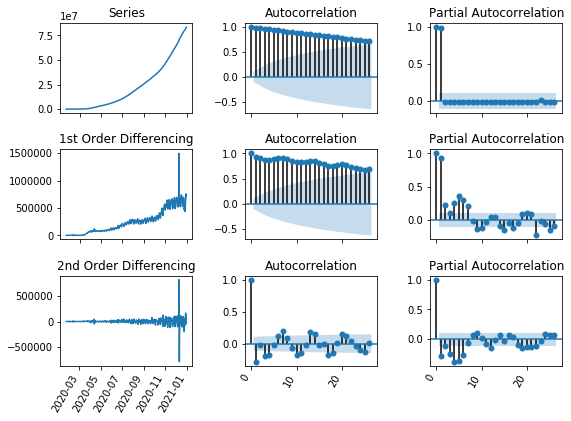

In [27]:
#series = np.log(data)
series = data
# Original Series
fig, axes = plt.subplots(3, 3,figsize=(9,7))
plt.subplots_adjust(wspace=0.4,hspace=0.4,)
axes[0, 0].plot(series)
axes[0, 0].set_title('Series')
plot_acf(series, ax=axes[0, 1])
plot_pacf(series,ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), ax=axes[1, 1])
plot_pacf(series.diff().dropna(),ax=axes[1, 2])
# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(series.diff().diff().dropna(),ax=axes[2, 2])
fig.autofmt_xdate(rotation=60)
plt.show()
fig.savefig("_images/acf.png")

**See clearly on charts**

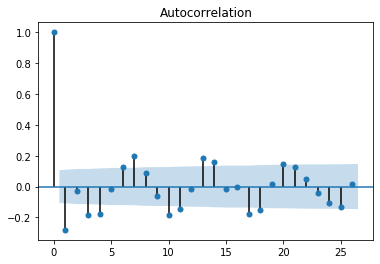

In [28]:
plot_acf(series.diff().diff().dropna())
plt.show()

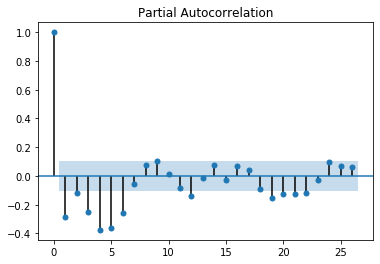

In [29]:
plot_pacf(series.diff().diff().dropna())
plt.show()

**Result:\
As we saw that data after log scaled and with diff twice had the most stable trend (smallest p-value of ADF test, so our transformation strategy would be loglized data and specify [d = 2] in ARIMA model. According to ACF/PACF chart p and q should both chose 1, but when diff equals 1 , p should chose 2 and q should chose 10.**

## Fit Model

/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.World   No. Observations:                  343
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4286.551
Method:                       css-mle   S.D. of innovations          64640.018
Date:                Sun, 31 Jan 2021   AIC                           8579.103
Time:                        15:38:18   BIC                           8590.616
Sample:                    01-24-2020   HQIC                          8583.689
                         - 12-31-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1871.0476    599.793      3.119      0.002     695.475    3046.620
ma.L1.D2.World    -0.8306      0.031    -26.717      0.000      -0.892      -0.770
                                    

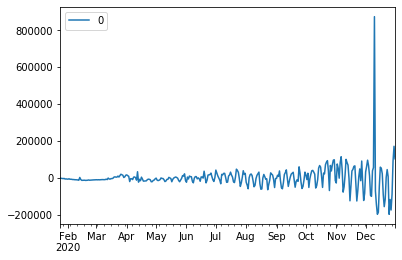

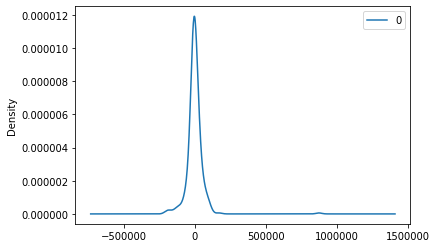

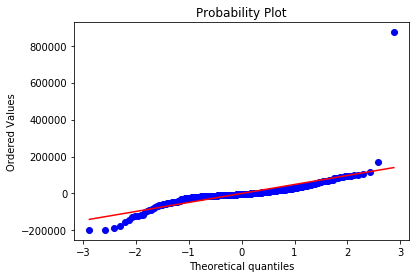

                   0
count     343.000000
mean      -39.827059
std     64734.684334
min   -197323.036776
25%    -13805.342910
50%     -3906.756256
75%     16255.645749
max    872748.692403


MSE:4178363509.4617505


In [31]:
# fit model
#series = np.log(data)
#series = data
series = df_train['World']
model = ARIMA(series, order=(0,2,1))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
res = np.array(residuals.values)
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
probplot(residuals.values.squeeze(),plot=plt)
plt.show()
# summary stats of residuals
print(residuals.describe())
print('\n')
print("MSE:{}".format((res*res).mean()))

### Save model

In [ ]:
# # save model
# model_fit.save('model.pkl')
# # load model
# loaded = ARIMAResults.load('model.pkl')

## Inverse back to origin data

In [32]:
FORCAST_PREIOD = PRED

In [33]:
LAST_DATE = df_train.index[-1]

In [34]:
index = pd.date_range(start=LAST_DATE+dt.timedelta(days=1), periods=FORCAST_PREIOD)
index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30'],
              dtype='datetime64[ns]', freq='D')

In [35]:
# df_pred = pd.DataFrame(np.exp(model_fit.forecast(FORCAST_PREIOD)[0]),index=index,columns=['pred'])
# df_conf = pd.DataFrame(np.exp(model_fit.forecast(FORCAST_PREIOD)[2]),columns=['lower','upper'],index=index)
df_pred = pd.DataFrame(model_fit.forecast(FORCAST_PREIOD)[0],index=index,columns=['pred'])
df_conf = pd.DataFrame(model_fit.forecast(FORCAST_PREIOD)[2],columns=['lower','upper'],index=index)

In [36]:
trend_chart = alt.Chart(df_train.reset_index()).mark_line().encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("World:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "US:Q"]
        ).properties(width=800, height=300).interactive()

actual_chart = alt.Chart(df_test.reset_index()).mark_line(color='green').encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("World:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "US:Q"]
        ).properties(width=800, height=300).interactive()

pred_chart = alt.Chart(df_pred.reset_index()).mark_line(strokeDash=[10,5],color='orange').encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("pred:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "pred:Q"]
        ).properties(width=800, height=300).interactive()

band = alt.Chart(df_conf.reset_index()).mark_area(
            opacity=0.5, color='grey'
        ).encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y('lower',title='cases'),
            y2=alt.Y2('upper',title='cases')
        ).properties(width=800, height=300).interactive()

trend_chart+actual_chart+pred_chart+band

alt.LayerChart(...)

In [37]:
def draw_trend(df_train,df_test,df_pred,df_conf,col):
    trend_chart = alt.Chart(df_train.reset_index()).mark_line().encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("{}:Q".format(col),scale=alt.Scale(zero=False)),
            tooltip=["index:T", "US:Q"]
        ).properties(width=800, height=300).interactive()

    actual_chart = alt.Chart(df_test.reset_index()).mark_line(color='green').encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("{}:Q".format(col),scale=alt.Scale(zero=False)),
            tooltip=["index:T", "US:Q"]
        ).properties(width=800, height=300).interactive()

    pred_chart = alt.Chart(df_pred.reset_index()).mark_line(strokeDash=[10,5],color='orange').encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("pred:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "pred:Q"]
        ).properties(width=800, height=300).interactive()

    band = alt.Chart(df_conf.reset_index()).mark_area(
            opacity=0.5, color='grey'
        ).encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y('lower',title='cases'),
            y2=alt.Y2('upper',title='cases')
        ).properties(width=800, height=300).interactive()

    return trend_chart+actual_chart+pred_chart+band

In [38]:
draw_trend(df_train,df_test,df_pred,df_conf,'World')

alt.LayerChart(...)

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
mean_squared_error(df_test['World'],df_pred)

161096313522.83163

In [41]:
mean_squared_error(df_test['World'],model_fit.forecast(FORCAST_PREIOD)[0])

161096313522.83163

### Grid search 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(df_train,df_val,col, p_values, d_values, q_values,FORCAST_PREIOD,save_file = False):
    
    dataset = df_train[col]
    dataset = dataset.astype('float32')
    val = df_val[col]
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit(disp=0)
                    mse = mean_squared_error(val,model_fit.forecast(FORCAST_PREIOD)[0])
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    model = ARIMA(dataset, order=best_cfg)
    model_fit = model.fit(disp=0)
    if save_file:
        # save model
        model_fit.save('c_models/{}_model.pkl'.format(col))
    return model_fit,best_cfg,best_score

In [ ]:
evaluate_models(df_train=df_train,df_val=df_test,col='World',p_values=range(0,3),d_values=range(0,3),q_values=range(0,2),FORCAST_PREIOD=FORCAST_PREIOD,save_file=True)

## Build models for top25 countries

In [ ]:
mse_data={}
cfg_data={}
for c in top_20_countries:
    model_fit, order, score = evaluate_models(df_train=df_train,
                    df_val=df_test,
                    col=c,
                    p_values=range(0,10,2),
                    d_values=range(0,3),
                    q_values=range(0,5),
                    FORCAST_PREIOD=FORCAST_PREIOD,
                    save_file=False)
    mse_data[c] = score
    cfg_data[c]= order
    

In [ ]:
mse_data

In [ ]:
import pickle 

In [ ]:
with open('arima_result.pkl', 'wb') as f:
    pickle.dump(mse_data,f)

In [ ]:
with open('arima_order.pkl', 'wb') as f:
    pickle.dump(cfg_data,f)